In [119]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageFilter
import math
from os import listdir
import random
import cv2
import pandas as pd

import pywt

import keras
from keras import backend as K
from keras.models import model_from_json
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam
from keras import regularizers, optimizers, losses, initializers

import tensorflow as tf
from tensorflow.python.client import device_lib

import skimage
from skimage import measure

from PIL import Image

In [2]:
from srcnn import *
from utility import *

%matplotlib inline

In [3]:
#Division by 4
window_size= 64
scale = 4
stride = 16

In [4]:
def calcPSNR(original,prediction):
    return measure.compare_psnr(original, prediction,data_range=256)

In [5]:
def calcSSIM(orig,pred):
    return measure.compare_ssim(orig,pred,data_range=256, multichannel=True)

In [6]:
def calcRMSE(orig,pred):
    return np.sqrt(measure.compare_mse(orig,pred))

In [7]:
#Returns original, bicubic and model prediction
def getImages(filename):
    im = Image.open("set14/"+filename)

    img = np.asarray(im.convert('YCbCr'))

    img = img[:,:,0]
    org, bic = get_input_images(img, 4)

    h, w = retSize(org)

    sub_img = getSubImages(bic)
    
    low_w = []
    for i in range(len(sub_img)):
        dwt_w = pywt.dwt2(sub_img[i], 'haar')

        dwt_w = np.asfarray([dwt_w[0], dwt_w[1][0], dwt_w[1][1], dwt_w[1][2]])

        low_w.append(dwt_w)
        
    low_wavelet = np.asarray(low_w)
    
    pred_w = model.predict(low_wavelet)
    
    res = low_wavelet + pred_w

    sub_imgs = []
    for i in range(len(res)) :
        patch = res[i]
        dwt = (patch[0], (patch[1], patch[2], patch[3]))
        wavelet = pywt.idwt2(dwt, 'haar')
        sub_imgs.append(wavelet)
        
    im = patch_to_image(sub_imgs, h, w)
    return org,bic,im

In [8]:
def convertToYCbCr(x):
    return [image.convert('YCbCr') for image in x]
	
	#Display images
def print_luminance(img, ch=1) :
    if (ch == 1) :
        plt.imshow(img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    else :
        plt.imshow(img[:,:,0], cmap=plt.get_cmap('gray'), interpolation='nearest')
		
def getSubImage(img, height, width, centerX, centerY, len_interval, scale = 1) :
    window = window_size // scale
    return img[ height   : height//2 + window + centerX*len_interval,
                width // 2  + centerY*len_interval : width//2 + window + centerY*len_interval : ]
				
def retSize(x):
    return (x.shape[0], x.shape[1])
	
def getSubImages(image, stride = stride) :
    sub = []
    height, width = retSize(image)
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            sub.append(image[h : h + window_size, w : w + window_size])
    return sub

def appendSubbands(l1,l2,l3,l4, dwt):
    l1 = np.append(l1 , dwt[0])
    l2 = np.append(l2, dwt[1][0])
    l3 = np.append(l3, dwt[1][1])
    l4 = np.append(l4, dwt[1][2])
    return (l1,l2,l3,l4)

def reshape(matrix, dwt_shape, channel='channels_last', ch=1) :
    if (channel == 'channels_last') :
        return matrix.reshape(-1, dwt_shape[0], dwt_shape[1], ch)
    else :
        return matrix.reshape(ch, -1, dwt_shape[0], dwt_shape[1])

def equals(a, b) :
    t = a == b
    count = 0
    for a in range(0, len(t)) :
        for b in range(len(t[0])) :
            for c in range(len(t[1])) :
                if ( t[a, b, c] == False):
                    count = count + 1
    return count / (32*32*4) < 0.20
    

def getSubImages(image, stride = stride) :
    sub = []
    height, width = retSize(image)
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            sub.append(image[h : h + window_size, w : w + window_size])
    return sub

def plot4images(im1, im2, im3, im4, ch=1) :
    size = (10, 10)
    fig = plt.figure(figsize=size)
    
    plt.subplot(221)
    plt.title("Approximation")
    print_luminance(im1, ch )
    plt.subplot(222)
    plt.title("Horizontal")
    print_luminance(im2, ch)
    plt.subplot(223)
    plt.title("Vertical")
    print_luminance(im3, ch)
    
    plt.subplot(224)
    plt.title("Diagonal")
    print_luminance(im4, ch)

def plot_waveletTrans(wt, ch=1) :
    plot4images(wt[0], wt[1][0], wt[1][1], wt[1][2], ch)



In [9]:
PATH = ""
TRAIN_FILE = PATH + "set14/"
obj_files = sorted(listdir(TRAIN_FILE )) #the filenames  the call to sorted is actually necessary to ensure independence to filesystems

In [10]:
high_res=obj_files[0::2]
low_res=obj_files[1::2]

In [11]:
model_grey = load_model("SRCNN_deep")
#model.summary()

In [12]:
model_r = load_model("SRCNN_red_channel")
model_g = load_model("SRCNN_green_channel")
model_b = load_model("SRCNN_blue_channel")
model_space= load_model("sptial_deep_model")

In [13]:
#This method assumes it gets a picture with mirror padding.
#It basically recreates said picture from patches and then crops accordingly to get back the good picture
def patch_to_image(patches, height, width, strides=stride, window_size=64) :
    count = 0
    if(len(patches[0].shape) == 3):
        img = np.zeros((int(np.ceil(height/stride))*window_size, int(np.ceil(width/stride))*window_size,3))
    else:
        img = np.zeros((int(np.ceil(height/stride))*window_size, int(np.ceil(width/stride))*window_size))    
    for h in range(0, height, stride) :
        for w in range (0, width, stride) : 
            if(len(patches[count].shape) == 3):
                img[h : h + window_size, w : w + window_size,:] = patches[count]
            else:
                img[h : h + window_size, w : w + window_size,] = patches[count]
            count = count + 1
    return img[:height, :width]

#This method basically takes a picture and applies mirror-folding boundary conditions to it.
#This way, we actually don't have to put "black" pixels when near borders, which is better for our transforms
def getSubImages(image, stride = stride, window_size=64) :
    sub = []
    height, width = retSize(image)
    moar = False
    if(len(image.shape) == 3):
        moar= True
    for h in range(0, height, stride) :
        for w in range (0, width, stride) : 
            x = h+window_size
            y = w+window_size
            i = h
            j = w
            concatX = False
            concatY = False
            if(x >= height):
                x = x-height
                if(y>= width):
                    y = y-width
                    i1 = image[h:height, w:width, :] if moar else image[h:height, w:width]
                    i2 = np.flip(image,axis=1)[h:height,0:y,:] if moar else np.flip(image,axis=1)[h:height,0:y]
                    i3 = np.flip(np.flip(image, axis=0), axis=1)[0:x,0:y,:] if moar else np.flip(np.flip(image, axis=0), axis=1)[0:x,0:y]
                    i4 = np.flip(image, axis=0)[0:x, w:width,:] if moar else np.flip(image, axis=0)[0:x, w:width] 
                    e = np.concatenate((np.concatenate((i1,i2), axis=1),np.concatenate((i3,i4), axis=1)), axis=0)
                else:
                    a = image[h:height, w:y, :] if moar else image[h:height, w:y]
                    b = np.flip(image, axis=0)[0:x, w:y,:] if moar else np.flip(image, axis=0)[0:x, w:y]
                    e = np.concatenate((a,b), axis=0)
            elif(y >= width):
                y = y-width
                a = image[h:x, w:width,:] if moar else image[h:x, w:width]
                b = np.flip(image,axis=1)[h:x, 0:y,:] if moar else np.flip(image,axis=1)[h:x, 0:y]
                e = np.concatenate((a,b), axis=1)
            else:
                e = image[h:x, w:y,:] if moar else image[h:x, w:y]
            sub.append(e)
    return sub


#Returns original, bicubic and model prediction

def getSpacePred(org, bic, modelspace):
    h, w = retSize(bic)
    if(len(bic.shape) != 3): #meaning we've a greyscale image
        bic = np.stack((bic,bic,bic), axis=2)
    sub_img = getSubImages(bic,window_size=32)
    print(np.asarray(sub_img).shape)
    
    pred_s = modelspace.predict(np.asarray(sub_img),64)
    
    im_sp = patch_to_image(pred_s, h, w, window_size=32)
    return im_sp#np.uint8((im-np.min(im))/(np.max(im)-np.min(im))*255)

def getImages(img, modelfreq):
    org, bic = get_input_images(img, 4)

    h, w = retSize(org)

    sub_img = getSubImages(bic)
    
    low_w = []
    for i in range(len(sub_img)):
        dwt_w = pywt.dwt2(sub_img[i], 'haar')

        dwt_w = np.asfarray([dwt_w[0], dwt_w[1][0], dwt_w[1][1], dwt_w[1][2]])

        low_w.append(dwt_w)
        
    low_wavelet = np.asarray(low_w)
    
    pred_w = modelfreq.predict(low_wavelet)
    
    res = low_wavelet + pred_w
    
    
    sub_imgs = []
    for i in range(len(res)) :
        patch = res[i]
        dwt = (patch[0], (patch[1], patch[2], patch[3]))
        wavelet = pywt.idwt2(dwt, 'haar')
        sub_imgs.append(wavelet)
        
    im = patch_to_image(sub_imgs, h, w)
    return org,bic, im#np.uint8((im-np.min(im))/(np.max(im)-np.min(im))*255)

def getColourImages(filename):
    img = Image.open("set14/"+filename)
    img = np.asarray(img)
    if(len(img.shape) == 3):
        im_r = img[:,:,0]
        im_g = img[:,:,1]
        im_b = img[:,:,2]
        org_r, bic_r, im_r = getImages(im_r,model_r)
        org_g, bic_g, im_g = getImages(im_g,model_g)
        org_b, bic_b, im_b = getImages(im_b,model_b)
        org = np.stack((org_r, org_g, org_b), axis=2)
        bic = np.stack((bic_r, bic_g, bic_b), axis=2)
        im = np.stack((im_r, im_g, im_b), axis=2)
    else:
        im = Image.open("set14/"+filename)
        img = np.asarray(im.convert('YCbCr'))
        org, bic,im= getImages(img[:,:,0],model_grey)

    space_pred = getSpacePred(org, bic, model_space)
    
    return org, bic, im, space_pred
    

In [14]:
results=[]

for f in high_res:
    print(f)
    org,bic,pred, space_pred=getColourImages(f)
    if(len(org.shape) != 3):
        space_pred = space_pred[:,:,0]
    results.append((org,bic,pred, space_pred))
    
np.save("results", results)

img_001_SRF_4_HR.png
(960, 32, 32, 3)
img_002_SRF_4_HR.png
(1620, 32, 32, 3)
img_003_SRF_4_HR.png
(1024, 32, 32, 3)
img_004_SRF_4_HR.png
(396, 32, 32, 3)
img_005_SRF_4_HR.png
(368, 32, 32, 3)
img_006_SRF_4_HR.png
(324, 32, 32, 3)
img_007_SRF_4_HR.png
(736, 32, 32, 3)
img_008_SRF_4_HR.png
(396, 32, 32, 3)
img_009_SRF_4_HR.png
(1024, 32, 32, 3)
img_010_SRF_4_HR.png
(1024, 32, 32, 3)
img_011_SRF_4_HR.png
(1536, 32, 32, 3)
img_012_SRF_4_HR.png
(1024, 32, 32, 3)
img_013_SRF_4_HR.png
(1353, 32, 32, 3)
img_014_SRF_4_HR.png
(925, 32, 32, 3)


In [144]:
#f=np.load("results.npy")

In [15]:
def convertToPicture(img):
    if(len(img.shape) == 3):
        img = Image.fromarray(img, 'RGB')
    else:
        img = Image.fromarray(img)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

In [16]:
def plot_results(i):
    result=results[i]
    org=result[0].astype(float)
    bic=result[1].astype(float)
    sr=result[2].astype(float)
    spred=result[3].astype(float)
    
    psnr_bic=round(calcPSNR(org,bic),4)
    psnr_sr=round(calcPSNR(org,sr),4)
    psnr_sd=round(calcPSNR(org, spred),4)
    org,bic,sr, spred = ims[i]
    
    plot_images([org,bic,sr, spred], ["Original", "Bic (PSNR: "+str(psnr_bic)+")", "SR (PSNR: "+str(psnr_sr)+")", "Spatial (PSNR: "+str(psnr_sd)+")"], size= (20,20), ch=1)

In [17]:
i=0
ims = []
for res in results:
    im_w = convertToPicture(np.uint8(np.clip(res[2],0,255)))
    im_s = convertToPicture(np.uint8(np.clip(res[3],0,255)))
    im_w.save("srcnn_results/"+str(i)+".png")
    i=i+1
    ims.append((convertToPicture(res[0]), convertToPicture(res[1]),im_w, im_s))

In [18]:
def calculate_measures(measure):
    bic_values=[]
    sr_values=[]
    spatial_values=[]

    indexValues=[]
    
    cols=["Bicubic","SRCNN","Spatial SRCNN"]
    cols=[x+" "+measure for x in cols]

    i=1
    for result in results:
        org=result[0].astype(float)
        bic=result[1].astype(float)
        sr=result[2].astype(float)
        spatial=result[3].astype(float)
        
        if measure=="psnr":
            bic_values.append(round(calcPSNR(org,bic),4))
            sr_values.append(round(calcPSNR(org,sr),4))
            spatial_values.append(round(calcPSNR(org,spatial),4))

        if measure=="rmse":
            bic_values.append(round(calcRMSE(org,bic),4))
            sr_values.append(round(calcRMSE(org,sr),4))
            spatial_values.append(round(calcRMSE(org,spatial),4))

        if measure=="ssim":
            bic_values.append(round(calcSSIM(org,bic),4))
            sr_values.append(round(calcSSIM(org,sr),4))
            spatial_values.append(round(calcSSIM(org,spatial),4))
            
        indexValues.append("Image "+str(i))
        i=i+1
        
    df=pd.DataFrame(data=[bic_values,sr_values,spatial_values]).transpose()
    df.columns=cols
    df.index=indexValues
    
    return df

In [99]:
def plotMeanStd(df,measure):
    mean_values=[]
    std_values=[]
    
    mean_values.append(df["Bicubic "+measure].mean())
    mean_values.append(df["SRCNN "+measure].mean())
    mean_values.append(df["Spatial SRCNN "+measure].mean())
    
    std_values.append(df["Bicubic "+measure].std())
    std_values.append(df["SRCNN "+measure].std())
    std_values.append(df["Spatial SRCNN "+measure].std())
    
    
    xticks=['Bic','SR','SR+Spatial']
    x = np.array([1, 2, 3])
    
    plt.xticks(x,xticks)
    plt.errorbar(x, mean_values, std_values, linestyle='None', ecolor="red",marker='o')
    plt.show()

In [107]:
#Will find values that are greater than 1 std away from mean
def find_outliers(df,col):
    mean=df[col].mean()
    std=df[col].std()
    return df[(df[col]>mean+std) | (df[col]<mean-std)][col]

<h2>PSNR</h2>

In [100]:
df_psnr=calculate_measures("psnr")

In [109]:
df_psnr

Bicubic psnr  SRCNN psnr  Spatial SRCNN psnr
Image 1        18.8348     19.3540             18.7207
Image 2        22.4004     22.5109             22.2308
Image 3        21.7392     22.1592             21.5970
Image 4        22.0805     22.5071             22.2161
Image 5        18.9779     19.4425             18.9378
Image 6        27.9365     28.2481             27.8356
Image 7        22.8296     23.1770             22.4795
Image 8        25.1871     25.8813             24.7478
Image 9        27.4372     28.0142             27.2631
Image 10       23.2961     23.7854             23.3619
Image 11       25.4490     26.1455             25.6864
Image 12       25.8708     26.3907             25.2441
Image 13       19.4212     19.7434             18.9309
Image 14       22.4035     22.8707             22.0617

In [115]:
print(df_psnr.idxmin())
print("")
print(df_psnr.idxmax())

Bicubic psnr          Image 1
SRCNN psnr            Image 1
Spatial SRCNN psnr    Image 1
dtype: object

Bicubic psnr          Image 6
SRCNN psnr            Image 6
Spatial SRCNN psnr    Image 6
dtype: object


Lowest and highest PSNR was from image 1 and 6 respectively. Note that the lowest/highest value is consistent regardless
of method. We can find the images that either performed rather well or poorly by looking at how much they deviate from
mean (here looking at mean +- 1 std)

In [116]:
find_outliers(df_psnr,"Bicubic psnr")

Image 1     18.8348
Image 5     18.9779
Image 6     27.9365
Image 9     27.4372
Image 13    19.4212
Name: Bicubic psnr, dtype: float64

In [117]:
find_outliers(df_psnr,"SRCNN psnr")

Image 1     19.3540
Image 5     19.4425
Image 6     28.2481
Image 9     28.0142
Image 13    19.7434
Name: SRCNN psnr, dtype: float64

In [118]:
find_outliers(df_psnr,"Spatial SRCNN psnr")

Image 1     18.7207
Image 5     18.9378
Image 6     27.8356
Image 9     27.2631
Image 13    18.9309
Name: Spatial SRCNN psnr, dtype: float64

For all 3 methods, it was the same set of images that deviates a lot.<br>
Low measure: Image 1, 5, 13 <br>
High measure: Image 6, 9

Plot of mean and standard deviation for all 3 methods 

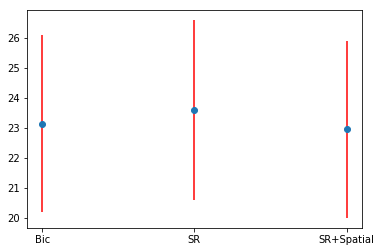

In [106]:
plotMeanStd(df_psnr,"psnr")

<h2>RMSE</h2>

In [85]:
df_rmse=calculate_measures("rmse")

In [86]:
df_rmse

Bicubic rmse  SRCNN rmse  Spatial SRCNN rmse
Image 1        29.2752     27.5767             29.6624
Image 2        19.4188     19.1731             19.8017
Image 3        20.9547     19.9656             21.3004
Image 4        20.1472     19.1816             19.8351
Image 5        28.7967     27.2970             28.9300
Image 6        10.2664      9.9046             10.3863
Image 7        18.4825     17.7578             19.2426
Image 8        14.0891     13.0069             14.8200
Image 9        10.8738     10.1750             11.0939
Image 10       17.5160     16.5565             17.3837
Image 11       13.6707     12.6172             13.3022
Image 12       13.0227     12.2660             13.9970
Image 13       27.3642     26.3675             28.9532
Image 14       19.4117     18.3952             20.1909

In [146]:
print(df_rmse.idxmin())
print("")
print(df_rmse.idxmax())

Bicubic rmse          Image 6
SRCNN rmse            Image 6
Spatial SRCNN rmse    Image 6
dtype: object

Bicubic rmse          Image 1
SRCNN rmse            Image 1
Spatial SRCNN rmse    Image 1
dtype: object


In [149]:
find_outliers(df_rmse,"Bicubic rmse")

Image 1     29.2752
Image 5     28.7967
Image 6     10.2664
Image 9     10.8738
Image 13    27.3642
Name: Bicubic rmse, dtype: float64

In [150]:
find_outliers(df_rmse,"SRCNN rmse")

Image 1     27.5767
Image 5     27.2970
Image 6      9.9046
Image 9     10.1750
Image 13    26.3675
Name: SRCNN rmse, dtype: float64

In [151]:
find_outliers(df_rmse,"Spatial SRCNN rmse")

Image 1     29.6624
Image 5     28.9300
Image 6     10.3863
Image 9     11.0939
Image 13    28.9532
Name: Spatial SRCNN rmse, dtype: float64

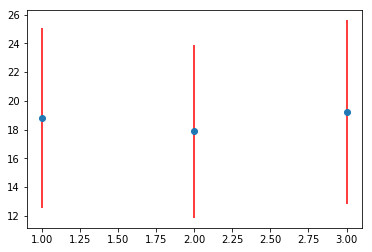

In [87]:
plotMeanStd(df_rmse,"rmse")

<h2>SSIM</h2>

In [89]:
df_ssim=calculate_measures("ssim")

In [90]:
df_ssim

Bicubic ssim  SRCNN ssim  Spatial SRCNN ssim
Image 1         0.4195      0.4257              0.3828
Image 2         0.6663      0.6688              0.6414
Image 3         0.5313      0.5411              0.5064
Image 4         0.4791      0.5078              0.4828
Image 5         0.6138      0.6199              0.5884
Image 6         0.6820      0.6884              0.6693
Image 7         0.7122      0.7190              0.6582
Image 8         0.8384      0.8655              0.8228
Image 9         0.7432      0.7507              0.7073
Image 10        0.6629      0.6686              0.6437
Image 11        0.8718      0.8794              0.8574
Image 12        0.7510      0.7589              0.6867
Image 13        0.8203      0.8242              0.7238
Image 14        0.7039      0.6839              0.6639

In [152]:
print(df_ssim.idxmin())
print("")
print(df_ssim.idxmax())

Bicubic ssim          Image 1
SRCNN ssim            Image 1
Spatial SRCNN ssim    Image 1
dtype: object

Bicubic ssim          Image 11
SRCNN ssim            Image 11
Spatial SRCNN ssim    Image 11
dtype: object


In [153]:
find_outliers(df_ssim,"Bicubic ssim")

Image 1     0.4195
Image 3     0.5313
Image 4     0.4791
Image 8     0.8384
Image 11    0.8718
Image 13    0.8203
Name: Bicubic ssim, dtype: float64

In [159]:
find_outliers(df_ssim,"SRCNN ssim")

Image 1     0.4257
Image 3     0.5411
Image 4     0.5078
Image 8     0.8655
Image 11    0.8794
Image 13    0.8242
Name: SRCNN ssim, dtype: float64

In [158]:
find_outliers(df_ssim,"Spatial SRCNN ssim")

Image 1     0.3828
Image 3     0.5064
Image 4     0.4828
Image 8     0.8228
Image 11    0.8574
Name: Spatial SRCNN ssim, dtype: float64

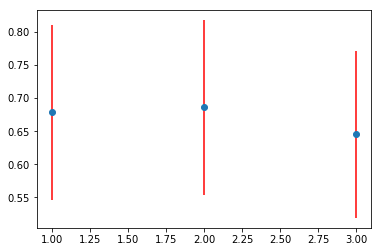

In [91]:
plotMeanStd(df_ssim,"ssim")

PSNR and RMSE behave similarly in regards to which images where super resolved the best and worst and which ones. SSIM on the other hand has a different subset of images with measures far from mean.

<h2>Plots</h2>

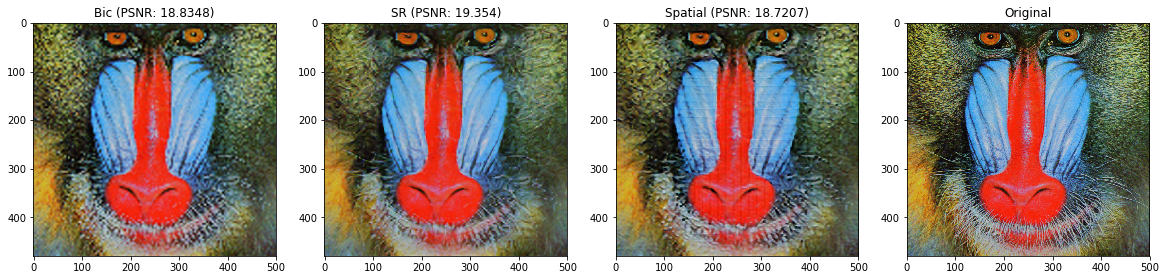

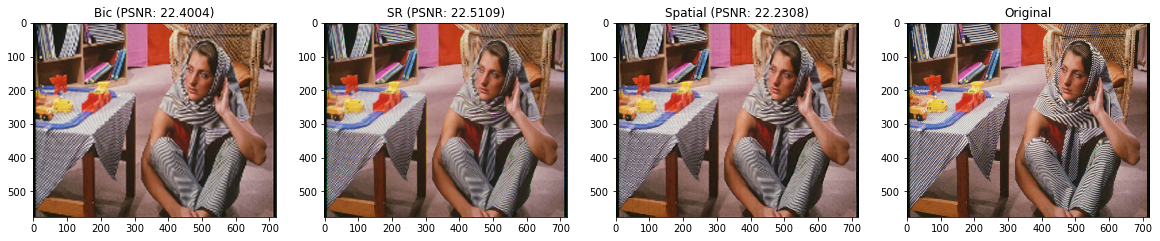

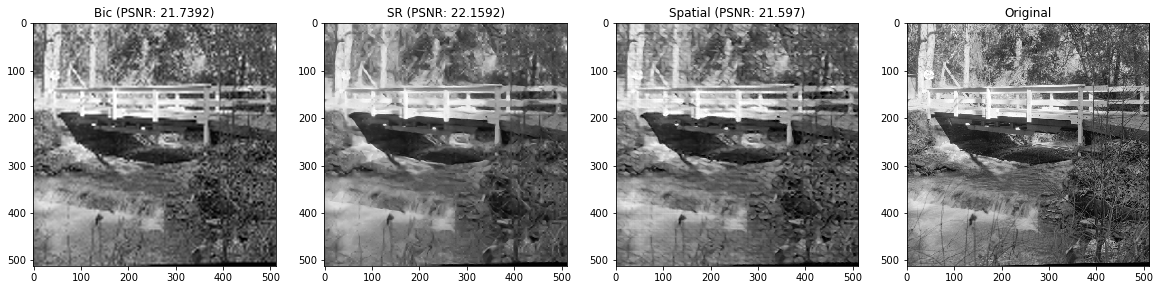

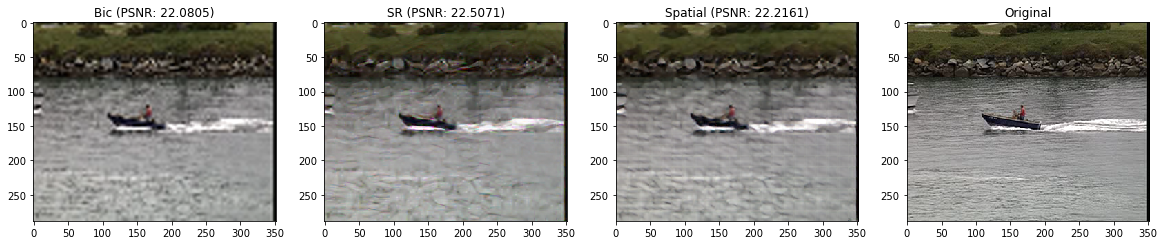

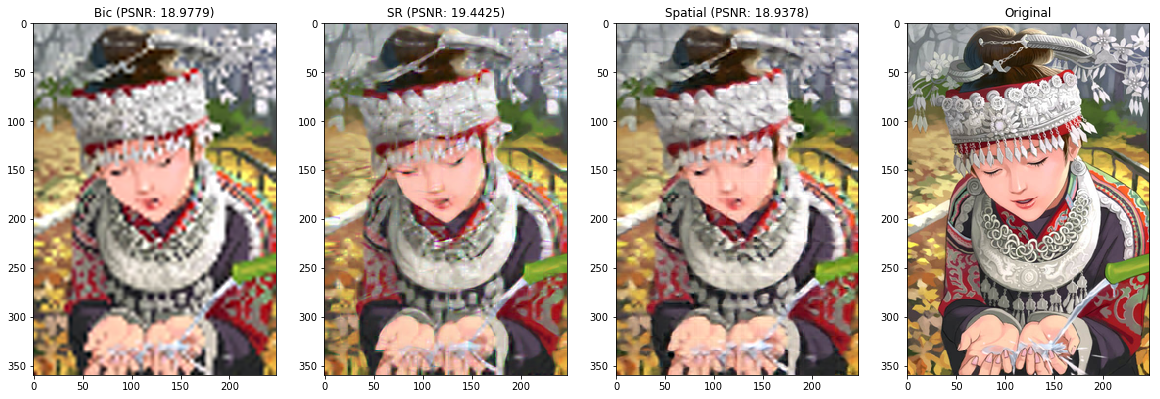

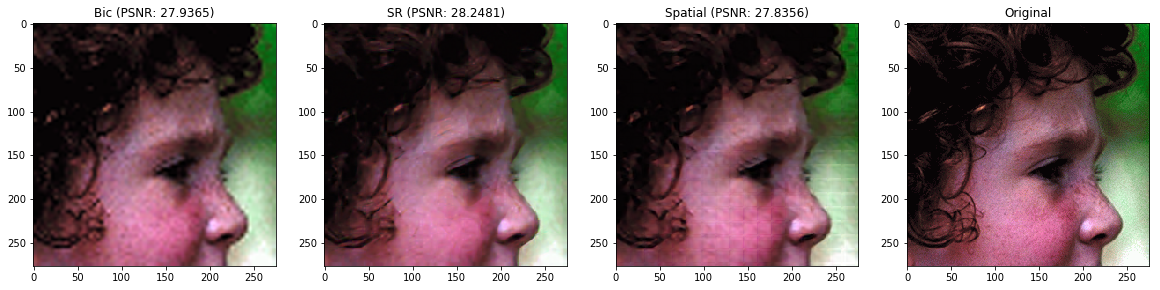

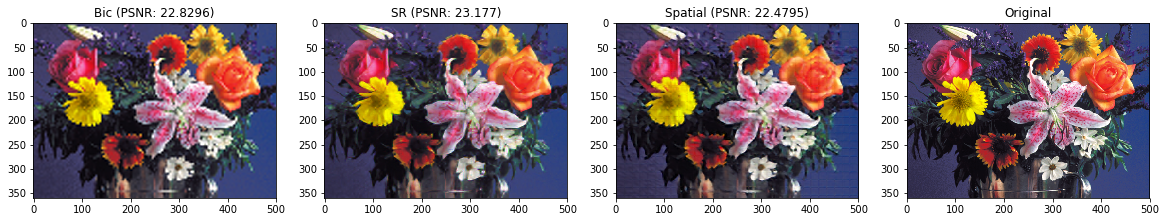

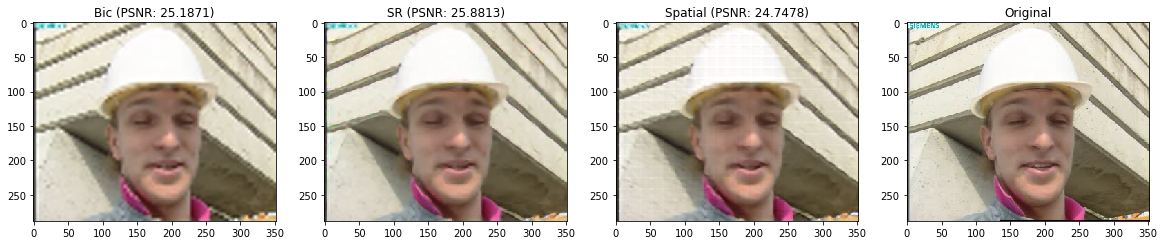

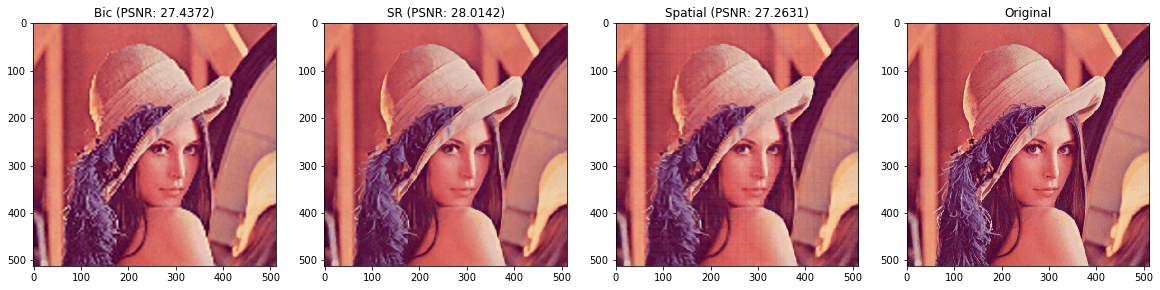

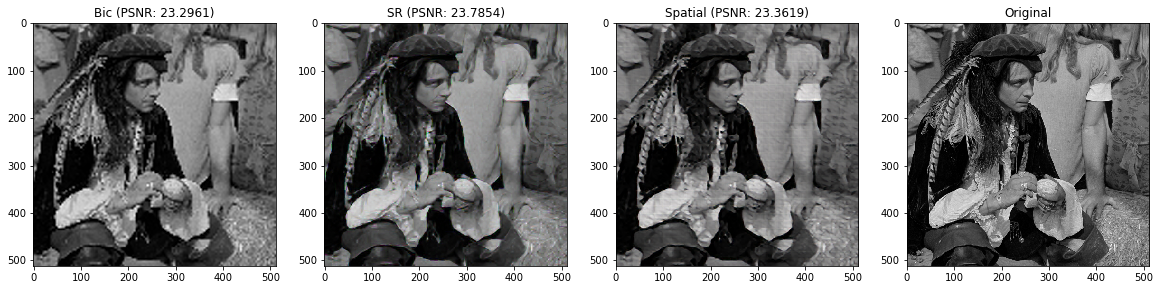

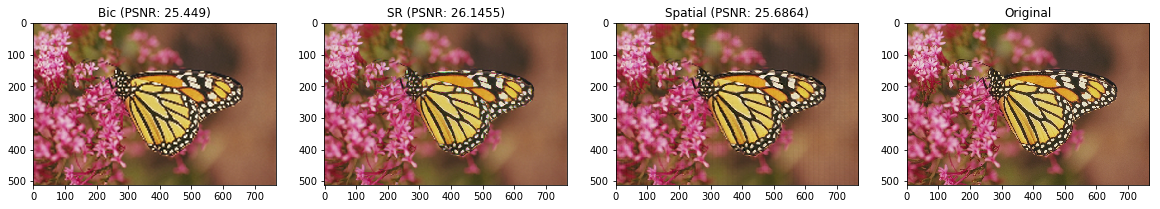

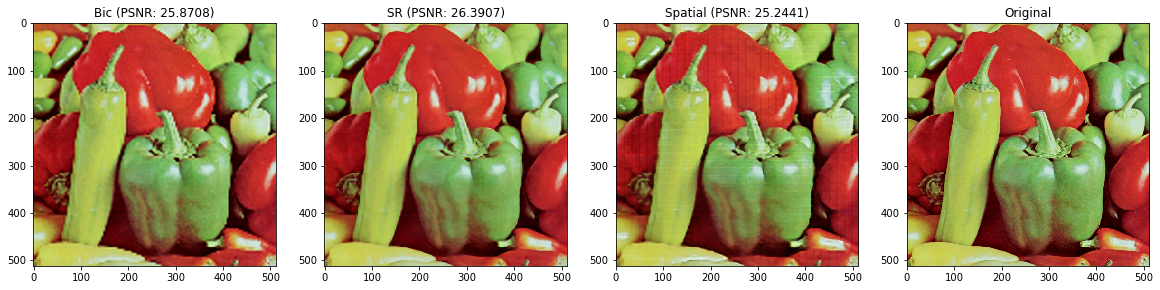

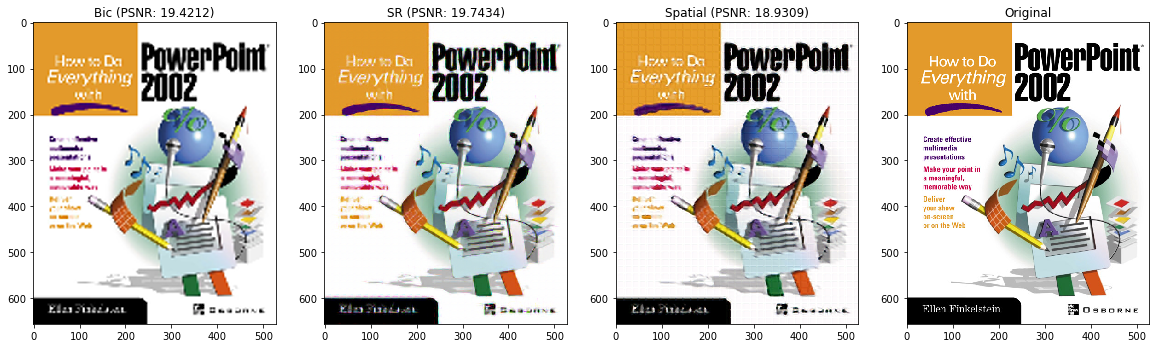

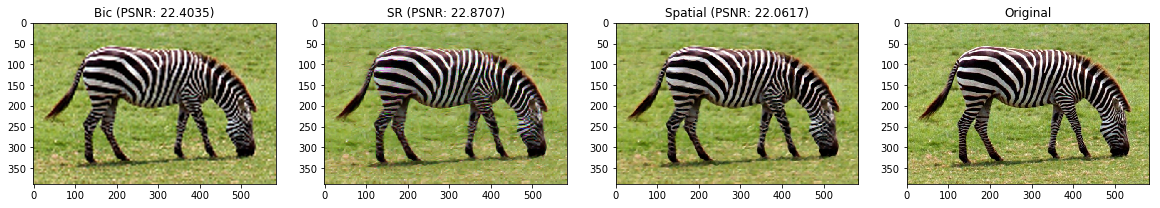

In [160]:
for i in range(14):
    plot_results(i)